# 프로젝트 : 향상된 U-Net

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

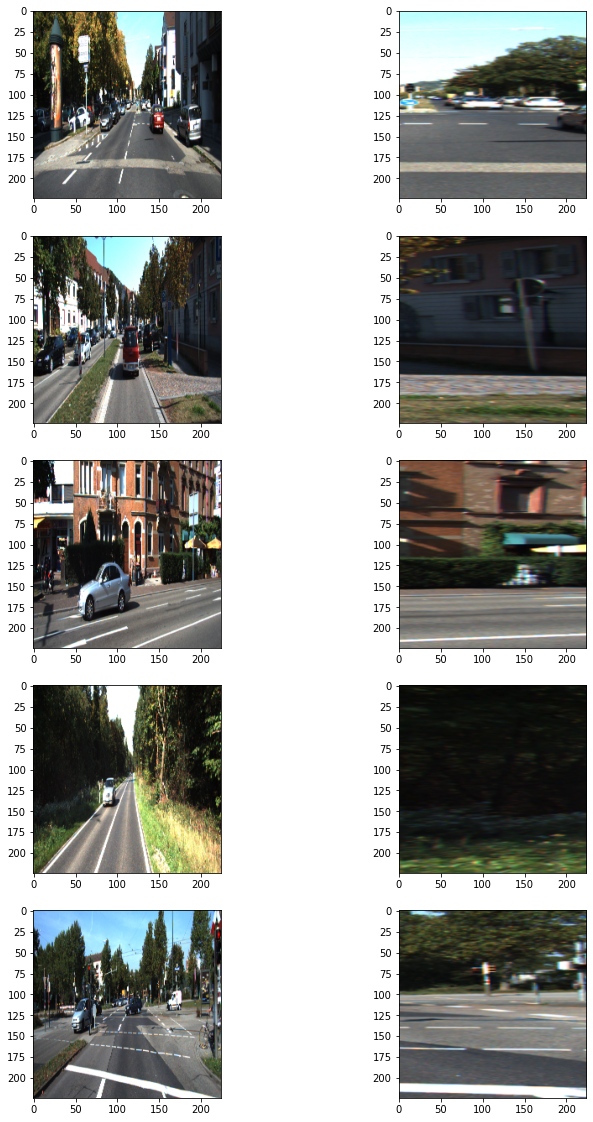

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"]) # 오른쪽이 augment된 이미지
    
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [6]:
# unet
def build_unet(input_shape=(224,224,3)):
    inputs = Input(input_shape)
    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
   
  #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
# unet++
def build_unetpp(input_shape=(224,224,3),n=32):
    inputs = Input(input_shape)
    filters = [n,n*2,n*4,n*8,n*16]
    #block depth col
    #block 0 0
    conv00 = Conv2D(filters[0], 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv00 = BatchNormalization()(conv00)
    conv00 = Activation('relu')(conv00)
    conv00 = Conv2D(filters[0], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv00)
    conv00 = BatchNormalization()(conv00)
    conv00 = Activation('relu')(conv00)
    
    conv00_down = MaxPooling2D(pool_size=(2,2))(conv00)
    
    #block 1 0
    conv10 = Conv2D(filters[1], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv00_down)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    conv10 = Conv2D(filters[1], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    
    conv10_down = MaxPooling2D(pool_size=(2,2))(conv10)
    
    #block 2 0
    conv20 = Conv2D(filters[2], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv10_down)
    conv20 = BatchNormalization()(conv20)
    conv20 = Activation('relu')(conv20)
    conv20 = Conv2D(filters[2], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv20)
    conv20 = BatchNormalization()(conv20)
    conv20 = Activation('relu')(conv20)
    
    conv20_down = MaxPooling2D(pool_size=(2,2))(conv20)
    
    #block 3 0
    conv30 = Conv2D(filters[3], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv20_down)
    conv30 = BatchNormalization()(conv30)
    conv30 = Activation('relu')(conv30)
    conv30 = Conv2D(filters[3], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv30)
    conv30 = BatchNormalization()(conv30)
    conv30 = Activation('relu')(conv30)
    
    conv30_down = MaxPooling2D(pool_size=(2,2))(conv30)
    
    #block 4 0
    conv40 = Conv2D(filters[4], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv30_down)
    conv40 = BatchNormalization()(conv40)
    conv40 = Activation('relu')(conv40)
    conv40 = Conv2D(filters[4], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv40)
    conv40 = BatchNormalization()(conv40)
    conv40 = Activation('relu')(conv40)
    
    conv40_down = MaxPooling2D(pool_size=(2,2))(conv40)
    
    #block 0 1
    conv10_up = Conv2DTranspose(filters[0], 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv10)
    conv01_in = Concatenate()([conv00,conv10_up])
    
    conv01 = Conv2D(filters[0], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv01_in)
    conv01 = BatchNormalization()(conv01)
    conv01 = Activation('relu')(conv01)
    conv01 = Conv2D(filters[0], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv01)
    conv01 = BatchNormalization()(conv01)
    conv01 = Activation('relu')(conv01)
    
    #block 1 1
    conv20_up = Conv2DTranspose(filters[1], 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv20)
    conv11_in = Concatenate()([conv10,conv20_up])
    
    conv11 = Conv2D(filters[1], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv11_in)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    conv11 = Conv2D(filters[1], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv11)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    
    #block 2 1
    conv30_up = Conv2DTranspose(filters[2], 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv30)
    conv21_in = Concatenate()([conv20,conv30_up])
    
    conv21 = Conv2D(filters[2], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv21_in)
    conv21 = BatchNormalization()(conv21)
    conv21 = Activation('relu')(conv21)
    conv21 = Conv2D(filters[2], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv21)
    conv21 = BatchNormalization()(conv21)
    conv21 = Activation('relu')(conv21)
    
    #block 3 1
    conv40_up = Conv2DTranspose(filters[3], 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv40)
    conv31_in = Concatenate()([conv30,conv40_up])
    
    conv31 = Conv2D(filters[3], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv31_in)
    conv31 = BatchNormalization()(conv31)
    conv31 = Activation('relu')(conv31)
    conv31 = Conv2D(filters[3], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv31)
    conv31 = BatchNormalization()(conv31)
    conv31 = Activation('relu')(conv31)
    
    
    #block 0 2
    conv11_up = Conv2DTranspose(filters[0], 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv11)
    conv02_in = Concatenate()([conv00,conv01,conv11_up])
    
    conv02 = Conv2D(filters[0], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv02_in)
    conv02 = BatchNormalization()(conv02)
    conv02 = Activation('relu')(conv02)
    conv02 = Conv2D(filters[0], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv02)
    conv02 = BatchNormalization()(conv02)
    conv02 = Activation('relu')(conv02)
    
    #block 1 2
    conv21_up = Conv2DTranspose(filters[1], 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv21)
    conv12_in = Concatenate()([conv10,conv11,conv21_up])
    
    conv12 = Conv2D(filters[1], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv12_in)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation('relu')(conv12)
    conv12 = Conv2D(filters[1], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv12)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation('relu')(conv12)
    
    #block 2 2
    conv31_up = Conv2DTranspose(filters[2], 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv31)
    conv22_in = Concatenate()([conv20,conv21,conv31_up])
    
    conv22 = Conv2D(filters[2], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv22_in)
    conv22 = BatchNormalization()(conv22)
    conv22 = Activation('relu')(conv22)
    conv22 = Conv2D(filters[2], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv22)
    conv22 = BatchNormalization()(conv22)
    conv22 = Activation('relu')(conv22)
    
    #block 0 3
    conv12_up = Conv2DTranspose(filters[0], 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv12)
    conv03_in = Concatenate()([conv00,conv01,conv02,conv12_up])
    
    conv03 = Conv2D(filters[0], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv03_in)
    conv03 = BatchNormalization()(conv03)
    conv03 = Activation('relu')(conv03)
    conv03 = Conv2D(filters[0], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv03)
    conv03 = BatchNormalization()(conv03)
    conv03 = Activation('relu')(conv03)
    
    #block 1 3
    conv22_up = Conv2DTranspose(filters[1], 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv22)
    conv13_in = Concatenate()([conv10,conv11,conv12,conv22_up])
    
    conv13 = Conv2D(filters[1], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv13_in)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    conv13 = Conv2D(filters[1], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv13)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    
    #block 0 4
    conv13_up = Conv2DTranspose(filters[0], 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv13)
    conv04_in = Concatenate()([conv00,conv01,conv02,conv03,conv13_up])
    
    conv04 = Conv2D(filters[0], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv04_in)
    conv04 = BatchNormalization()(conv04)
    conv04 = Activation('relu')(conv04)
    conv04 = Conv2D(filters[0], 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv04)
    conv04 = BatchNormalization()(conv04)
    conv04 = Activation('relu')(conv04)
    
    output = Conv2D(1, 1, activation='sigmoid')(conv04)

    model = Model(inputs = inputs, outputs = output)
    return model

In [8]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unetpp.h5'

modelpp = build_unetpp()
modelpp.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
modelpp.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

modelpp.save(model_path)

Epoch 1/100
11/11 [==============================] - 51s 735ms/step - loss: 0.7068 - val_loss: 0.6894
Epoch 2/100
11/11 [==============================] - 7s 654ms/step - loss: 0.6902 - val_loss: 0.6888
Epoch 3/100
11/11 [==============================] - 7s 655ms/step - loss: 0.6890 - val_loss: 0.6878
Epoch 4/100
11/11 [==============================] - 7s 657ms/step - loss: 0.6841 - val_loss: 0.6870
Epoch 5/100
11/11 [==============================] - 7s 659ms/step - loss: 0.6788 - val_loss: 0.6880
Epoch 6/100
11/11 [==============================] - 7s 662ms/step - loss: 0.6768 - val_loss: 0.6870
Epoch 7/100
11/11 [==============================] - 7s 662ms/step - loss: 0.6706 - val_loss: 0.6867
Epoch 8/100
11/11 [==============================] - 7s 664ms/step - loss: 0.6692 - val_loss: 0.6852
Epoch 9/100
11/11 [==============================] - 7s 668ms/step - loss: 0.6670 - val_loss: 0.6848
Epoch 10/100
11/11 [==============================] - 7s 667ms/step - loss: 0.6662 - val_l

In [9]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_unet()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)

Epoch 1/100
11/11 [==============================] - 23s 614ms/step - loss: 0.6931 - val_loss: 0.6926
Epoch 2/100
11/11 [==============================] - 6s 582ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/100
11/11 [==============================] - 6s 581ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 4/100
11/11 [==============================] - 6s 579ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 5/100
11/11 [==============================] - 6s 579ms/step - loss: 0.6908 - val_loss: 0.6905
Epoch 6/100
11/11 [==============================] - 6s 579ms/step - loss: 0.6903 - val_loss: 0.6900
Epoch 7/100
11/11 [==============================] - 6s 581ms/step - loss: 0.6897 - val_loss: 0.6895
Epoch 8/100
11/11 [==============================] - 6s 578ms/step - loss: 0.6892 - val_loss: 0.6889
Epoch 9/100
11/11 [==============================] - 6s 580ms/step - loss: 0.6886 - val_loss: 0.6884
Epoch 10/100
11/11 [==============================] - 6s 579ms/step - loss: 0.6881 - val_l

In [15]:
model_path = dir_path + '/seg_model_unet.h5' 
model = tf.keras.models.load_model(model_path)

In [10]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [11]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

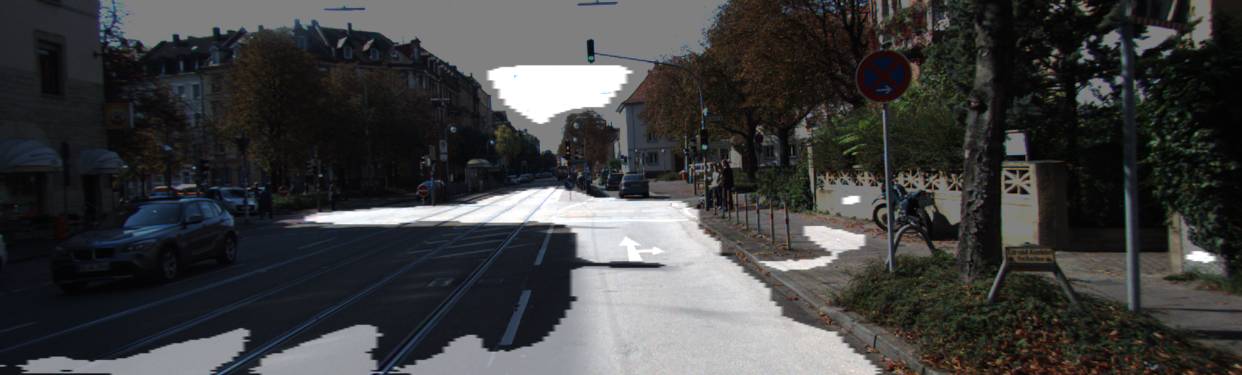

IoU : 0.419641


0.41964089410040306

In [16]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

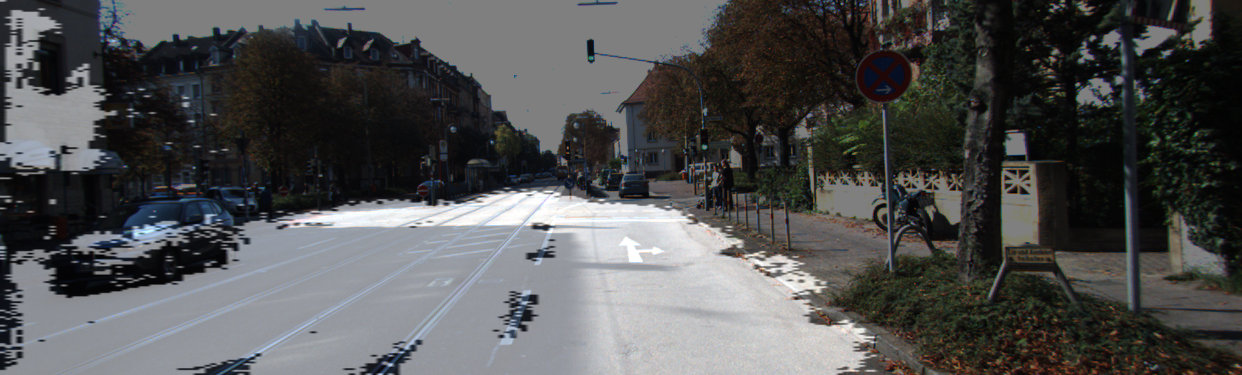

IoU : 0.817179


0.81717909830415

In [13]:

i = 1    
output, prediction, target = get_output(
     modelpp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

unet++은 스킵 커넥션을 이용해 성능을 향상시킨 모델입니다.
IoU가 아주 크게 향상된 것을 볼 수 있습니다.